In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad

from sklearn.datasets import fetch_20newsgroups

import gensim

from collections import Counter

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from tensorboardX import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter()

ImportError: No module named 'tensorboardX'

# Load and preprocess data

In [570]:
# Load documents
documents = fetch_20newsgroups(subset='train', remove=('headers', 'footers',  'quotes'), shuffle=True)

# Preprocess with gensim and remove stopwords
documents = [[word for word in gensim.utils.simple_preprocess(document) if not word in gensim.parsing.preprocessing.STOPWORDS]
             for document in documents['data'][:200]]

# Remove rare words by applying a frequency threshold
freq_threshold = 5
counts = Counter([word for document in documents for word in document])

documents = [list(filter(lambda word : counts[word] > freq_threshold, document)) for document in documents]
documents = list(filter(lambda document : len(document) > 0, documents))

# Map words to integer indices
counts = Counter([word for document in documents for word in document])

word_idx_dict = {word : i for i, word in enumerate(counts.keys())}
idx_word_dict = {i : word for word, i in word_idx_dict.items()}

documents = [torch.tensor(list(map(lambda word : word_idx_dict[word], document))) for document in documents]

In [571]:
class VariationalLDA(nn.Module):
    
    def __init__(self, documents, vocab_size, num_topics, log_eta, log_alpha):
        
        super(VariationalLDA, self).__init__()
        
        self.D = len(documents)
        self.K = num_topics
        self.V = vocab_size
        
        self.words = documents
        
        k_ones = torch.ones(size=(self.K,)).to(device)
        
        self.log_eta = nn.Parameter(torch.tensor(log_eta).to(device))
        self.log_alpha = nn.Parameter((log_alpha * k_ones + torch.rand(self.K).to(device)).to(device))
        
        self.gamma = [torch.exp(log_alpha * k_ones) + k_ones * len(Counter(document)) / self.K
                      for document in documents]
        
        self.phi = [torch.ones(size=(document.shape[0], self.K)).to(device) / self.K
                    for document in documents]
        
        self.lamda = torch.ones(size=(self.K, self.V)).to(device)
    
    
    def elbo(self):
        
        self.eta = torch.exp(self.log_eta)
        self.alpha = torch.exp(self.log_alpha)
        
        elbo = 0
        
        eta_vector = self.eta * torch.ones(self.V).to(device)
        
        lamda_digamma_diff = self.digamma_difference(self.lamda)
        gamma_digamma_diff = [self.digamma_difference(gamma_d) for gamma_d in self.gamma]
        
        eta_log_gamma_diff = self.log_gamma_difference(eta_vector)
        alpha_log_gamma_diff = self.log_gamma_difference(self.alpha)
        gamma_log_gamma_diff = [self.log_gamma_difference(gamma_d) for gamma_d in self.gamma]
        lamda_log_gamma_diff = self.log_gamma_difference(self.lamda)
        
        elbo = elbo + sum([torch.einsum('nk, kn ->', phi_d, lamda_digamma_diff[:, words_d])
                           for phi_d, words_d in zip(self.phi, self.words)])
        
        elbo = elbo + sum([torch.einsum('nk, k ->', phi_d, gamma_digamma_diff_d)
                           for phi_d, gamma_digamma_diff_d in zip(self.phi, gamma_digamma_diff)])
        
        elbo = elbo + self.D * alpha_log_gamma_diff
        
        elbo = elbo + sum([torch.einsum('k, k ->', self.alpha - 1, gamma_digamma_diff_d)
                           for gamma_digamma_diff_d in gamma_digamma_diff])
        
        elbo = elbo + self.K * eta_log_gamma_diff
        
        elbo = elbo + torch.einsum('v, kv ->', eta_vector - 1, lamda_digamma_diff)
        
        elbo = elbo - sum([torch.sum(phi_d * torch.log(phi_d)) for phi_d in self.phi])
        
        elbo = elbo - sum(gamma_log_gamma_diff)
        
        elbo = elbo - sum([torch.einsum('k, k ->', gamma_d - 1, gamma_digamma_diff_d)
                           for gamma_d, gamma_digamma_diff_d in zip(self.gamma, gamma_digamma_diff)])
        
        elbo = elbo - torch.sum(lamda_log_gamma_diff)
        
        elbo = elbo - torch.einsum('kv, kv ->', self.lamda - 1, lamda_digamma_diff)
        
        return elbo
    
    
    def forward(self):
        return - self.elbo()
    
    
    def variational_parameter_step(self):
        
        self.eta = torch.exp(self.log_eta.detach())
        self.alpha = torch.exp(self.log_alpha.detach())
        
        # Update gamma
        self.gamma = [(self.alpha + torch.sum(phi_d, dim=0)) for phi_d in self.phi]
        
        # Update lamda
        self.lamda = torch.ones((self.K, self.V)).to(device) * self.eta
        k_range = torch.arange(self.K)
        
        for d in range(self.D):
            for n in range(self.words[d].shape[0]):
                self.lamda[:, self.words[d][n]] += self.phi[d][n]
        
        # Update phi
        digamma_lamda = self.digamma_difference(self.lamda)
        words_digamma_lamda = [digamma_lamda[:, self.words[d]].T for d in range(self.D)]
        
        digamma_gamma = [torch.digamma(self.gamma[d]) - \
                         torch.digamma(torch.sum(self.gamma[d], dim=-1)[..., None]) for d in range(self.D)]
        
        self.phi = [torch.exp(words_digamma_lamda[d] + digamma_gamma[d]) for d in range(self.D)]
        self.phi = [phi_d / torch.sum(phi_d, dim=-1)[..., None] for phi_d in self.phi]
    
    
    def model_parameter_step(self):
        pass
    
    
    def perplexity(self):
        pass
    
    
    def digamma_difference(self, tensor):
        return torch.digamma(tensor) - torch.digamma(torch.sum(tensor, dim=-1)[..., None])
    
    
    def log_gamma_difference(self, tensor):
        return torch.lgamma(torch.sum(tensor, dim=-1)) - torch.sum(torch.lgamma(tensor), dim=-1)

In [507]:
lda = VariationalLDA(documents, len(counts), num_topics=3, log_eta=-1., log_alpha=-1.)

In [508]:
# optimizer = torch.optim.SGD(lda.parameters(), lr=1e-4)

# for i in range(100):
    
#     if i % 10 == 0:
#         print(torch.exp(lda.log_eta).cpu().detach().numpy())
        
#         print(torch.exp(lda.log_alpha).cpu().detach().numpy())

#     optimizer.zero_grad()

#     neg_elbo = - lda.elbo()

#     neg_elbo.backward()

#     optimizer.step()

In [509]:
num_em_iters = 10
num_e_steps, print_every_e = 100, 10
num_m_steps, print_every_m = 10, 1
verbose = False

optimizer = torch.optim.SGD(lda.parameters(), lr=1e-3)

for i in tqdm(range(num_em_iters)):
    
    for j in tqdm(range(num_m_steps), leave=False):

        lda.variational_parameter_step()
    
        if j % print_every_m == 0 and verbose:
            print(lda.gamma[0].cpu().detach().numpy())
            
    for j in tqdm(range(num_e_steps), leave=False):

        if j % print_every_e == 0 and verbose:
            print(torch.exp(lda.log_eta).cpu().detach().numpy())
            print(torch.exp(lda.log_alpha).cpu().detach().numpy())

        optimizer.zero_grad()

        neg_elbo = - lda.elbo()

        neg_elbo.backward()

        optimizer.step()

In [522]:
lamda, _ = torch.sort(lda.lamda[0])

<BarContainer object of 101 artists>

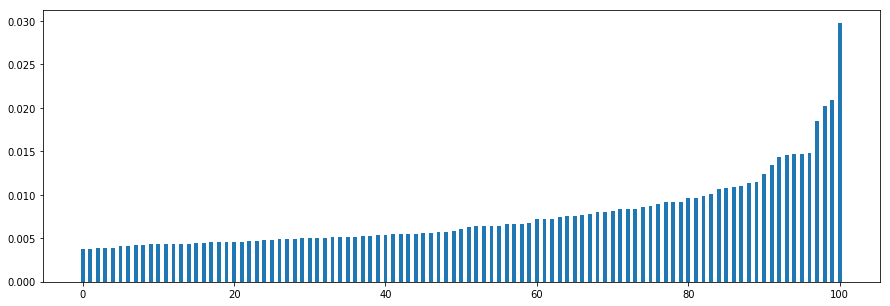

In [564]:
plt.figure(figsize=(15, 5))
beta, beta_idx = torch.sort(torch.distributions.dirichlet.Dirichlet(lda.lamda[0]).rsample())
y = beta.detach().cpu().numpy()[-101:]
x = torch.arange(len(y))
plt.bar(x, y, width=0.5)

In [569]:
for idx in beta_idx:
    
    print(idx_word_dict[int(idx)])

single
applications
work
help
rate
ns
california
pc
tell
gear
goes
example
insurance
encryption
phone
rushdie
cameras
turbo
software
car
game
gun
image
product
mb
live
personal
semi
want
email
info
age
gif
higher
reason
machine
line
case
ibm
appreciated
wrong
revolver
code
run
good
seen
thing
tis
cars
gpf
box
required
record
law
ll
mac
better
accidents
error
couple
things
access
available
thanks
parts
scsi
called
sure
problem
hard
including
treatment
need
god
fatwa
water
actually
mode
maybe
automatic
point
application
environment
lefthanded
ve
technology
religion
little
got
driving
com
question
said
chip
know
following
summary
response
note
religious
actions
think
request
probably
conference
mit
great
bit
starters
tiff
heard
open
defense
white
windows
miles
problems
uses
house
small
asked
worse
ago
times
child
set
auto
images
different
program
understanding
children
course
tried
th
book
comes
general
strong
university
place
best
non
right
going
important
parent
service
buy
edu
memory
h